In [14]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os
import matplotlib.pyplot as plt 
########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 3 # the lower limit of qubits for the circuit
upper_limit= 17 # the lower limit of qubits for the circuit
steps= 3 #jump in qubit numbers
name_of_algo='vqe'

In [15]:
#all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
#selected_fakes = random.sample(all_fakes, f)
#selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list
selected_fakes=[FakeBoeblingenV2,FakeRomeV2,FakeGeneva,FakeTorontoV2,FakeRochesterV2]

In [16]:
benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    benchmarks.append((supermarq.vqe_proxy.VQEProxy(num_qubits=i),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    #print(circuit[0].draw())       #uncomment it to print all the circuits

-------------------------- vqe3 ---------------------------
-------------------------- vqe6 ---------------------------
-------------------------- vqe9 ---------------------------
-------------------------- vqe12 ---------------------------
-------------------------- vqe15 ---------------------------


In [17]:
benchmark_features = {}
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_depth_with_qiskit((benchmark.qiskit_circuit())[0]),
        supermarq.converters.compute_depth_with_qiskit((benchmark.qiskit_circuit())[0]),
        supermarq.converters.compute_entanglement_with_qiskit((benchmark.qiskit_circuit())[0]),
        supermarq.converters.compute_liveness_with_qiskit((benchmark.qiskit_circuit())[0]),
        supermarq.converters.compute_measurement_with_qiskit((benchmark.qiskit_circuit())[0]),
        supermarq.converters.compute_parallelism_with_qiskit((benchmark.qiskit_circuit())[0]),]
print(benchmark_features)

{'vqe3': [1.0, 1.0, 0.14285714285714285, 0.9047619047619048, 0.0, 0.5], 'vqe6': [1.0, 1.0, 0.1724137931034483, 0.6666666666666666, 0.0, 0.38], 'vqe9': [1.0, 1.0, 0.18181818181818182, 0.5213675213675214, 0.0, 0.2980769230769231], 'vqe12': [1.0, 1.0, 0.1864406779661017, 0.4270833333333333, 0.0, 0.24431818181818182], 'vqe15': [1.0, 1.0, 0.1891891891891892, 0.36140350877192984, 0.0, 0.2067669172932331]}


In [18]:
import time
import pandas as pd
from IPython.display import display
jobs =[]
data=[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("BACKEND-NAME :: ", backend().name)
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        timetaken=[]
        for i in range(0,1):
            start=time.time()
            job = backend().run(circuit, shots=1000)
            result = job.result()
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            end=time.time()-start
            score_list.append(score)
            t=job.result(0).time_taken
            timetaken.append(t)
            #print(label ," ExecutionTime:",t,"& Total time:",end)
            print(i+1,"th iteration ,", label ,", Execution time::",t, ", Total Time Taken ::",end )
        print("------------------------------------------")
        score = np.mean(score_list) 
        sd = np.std(score_list)
        execution_time = np.mean(timetaken)
        dictionary={}
        dictionary["Backend_Time"]=backend().name
        dictionary["Ciruit_Name"]=label    
        dictionary["Execution_Time"]=execution_time
        dictionary["Total_Time"]=end
        data.append(dictionary)
        jobs.append((label,benchmark,backend,job,score,sd,execution_time,end))
#jobs
df = pd.DataFrame(data)
display(df)
df.to_excel(r"./output_VQE.xlsx", index=False)

=============SCORES OF ALL THE CIRCUITS=============
BACKEND-NAME ::  fake_boeblingen
1 th iteration , vqe3 , Execution time:: 0.07812738418579102 , Total Time Taken :: 0.3107473850250244
------------------------------------------
1 th iteration , vqe6 , Execution time:: 0.08104681968688965 , Total Time Taken :: 0.382462739944458
------------------------------------------
1 th iteration , vqe9 , Execution time:: 0.08861446380615234 , Total Time Taken :: 0.4462742805480957
------------------------------------------
1 th iteration , vqe12 , Execution time:: 0.38524627685546875 , Total Time Taken :: 0.7561697959899902
------------------------------------------
1 th iteration , vqe15 , Execution time:: 2.054889678955078 , Total Time Taken :: 2.688260555267334
------------------------------------------
BACKEND-NAME ::  fake_rome
1 th iteration , vqe3 , Execution time:: 0.022050142288208008 , Total Time Taken :: 0.08292245864868164
------------------------------------------
1 th iteration , 

,Backend_Time,Ciruit_Name,Execution_Time,Total_Time
0,fake_boeblingen,vqe3,0.078127,0.310747
1,fake_boeblingen,vqe6,0.081047,0.382463
2,fake_boeblingen,vqe9,0.088614,0.446274
3,fake_boeblingen,vqe12,0.385246,0.756170
4,fake_boeblingen,vqe15,2.054890,2.688261
5,fake_rome,vqe3,0.022050,0.082922
6,fake_rome,vqe6,0.023203,0.223215
7,fake_rome,vqe9,0.032395,0.098950
8,fake_rome,vqe12,0.252586,0.367209
9,fake_rome,vqe15,1.625576,1.960247


In [19]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    #print("SELCETED_FAKES:: ",i)
    i={}
    for label,benchmark,backend,job,score,sd,exec,tot in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   
#print(all_scores)    

In [20]:
for label,benchmark,backend,job,score,sd,exec,tot in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    #supermarq.plotting.plot_results([score], [label])
    print("-----------------------------------------------------------")

USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vqe3 ; SCORE = 0.919557431228867
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vqe6 ; SCORE = 0.9367754744741215
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vqe9 ; SCORE = 0.9638046510479823
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vqe12 ; SCORE = 0.9441742351810638
-----------------------------------------------------------
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: vqe15 ; SCORE = 0.8995438875876457
-----------------------------------------------------------
USED BACKEND:: fake_rome ; CIRCUIT_NAME: vqe3 ; SCORE = 0.9227419278605852
-----------------------------------------------------------
USED BACKEND:: fake_rome ; CIRCUIT_NAME: vqe6 ; SCORE = 0.956302845139479
-----------------------------------------------------------
USED BACKEND:: fake_rome 

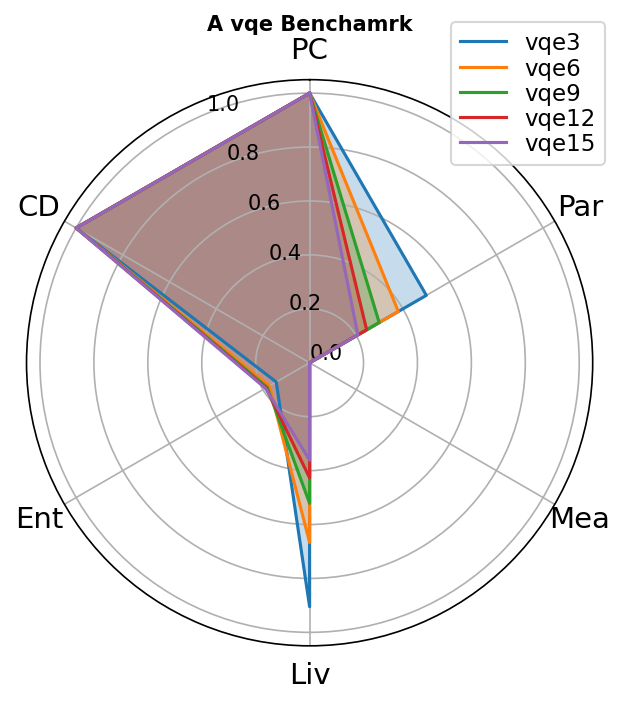

In [21]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
for i,j in benchmark_features.items():
    names.append(i)
    scores.append(j)
supermarq.plotting.plot_benchmark([X,names,scores],
        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],show=True)

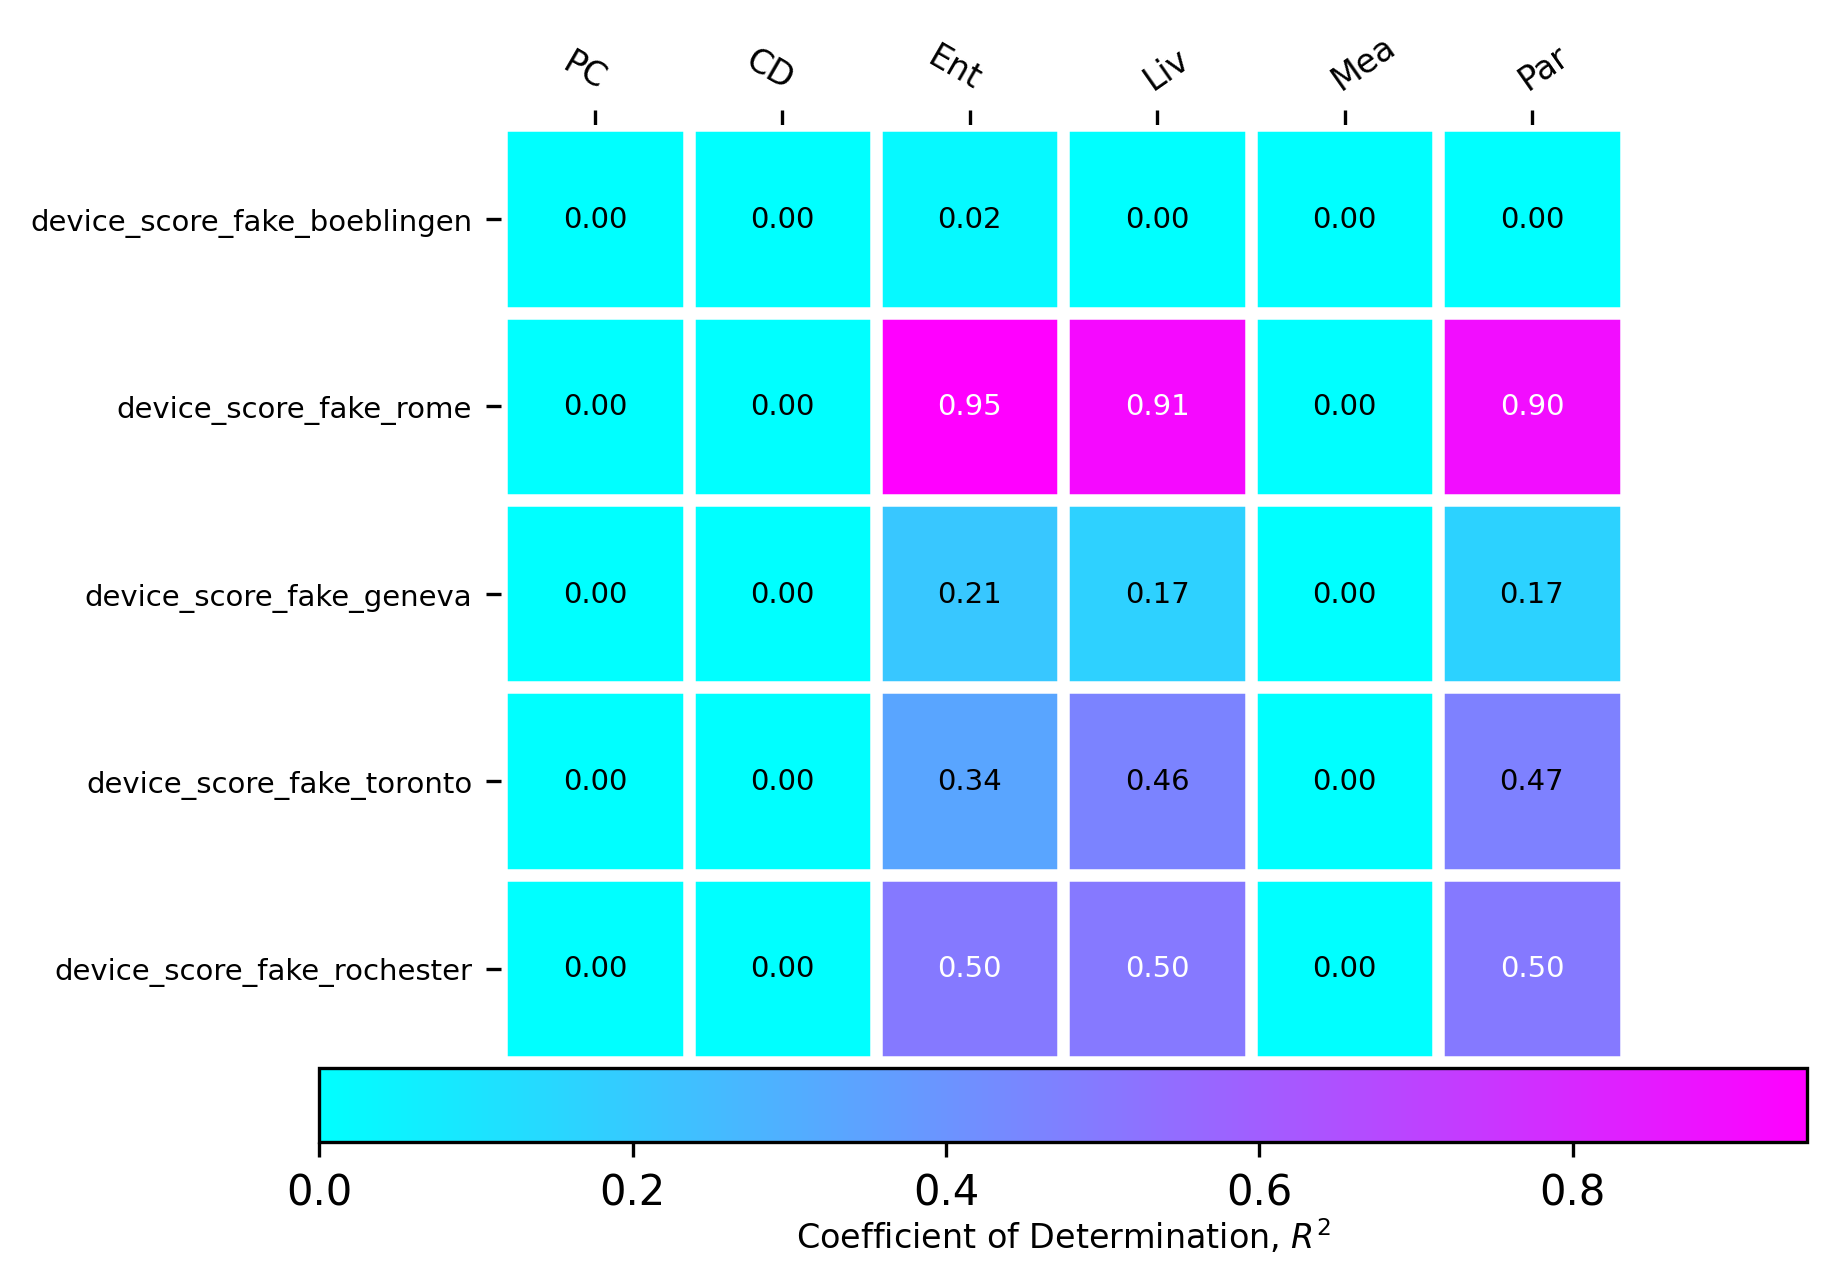

In [22]:
supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

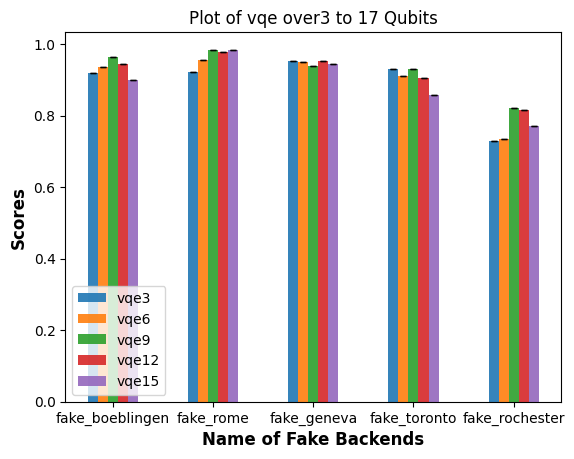

In [23]:
%matplotlib inline 

all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
v='Plot of '+name_of_algo+' over '+str(lower_limit)+' to '+str(upper_limit)+ ' Qubits'
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd,exec,tot in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title(v)
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()

In [24]:
import resource
def get_memory():
    usage = resource.getrusage(resource.RUSAGE_SELF)
    max_mem = usage.ru_maxrss/1024 #in MB
    return max_mem
get_memory()

792.28515625

In [30]:
all_fake_scores

[{'vqe3': 0.919557431228867,
  'vqe6': 0.9367754744741215,
  'vqe9': 0.9638046510479823,
  'vqe12': 0.9441742351810638,
  'vqe15': 0.8995438875876457},
 {'vqe3': 0.9227419278605852,
  'vqe6': 0.956302845139479,
  'vqe9': 0.9848384747807225,
  'vqe12': 0.9786366534282008,
  'vqe15': 0.9838430085881537},
 {'vqe3': 0.9527292711425978,
  'vqe6': 0.9503250786092678,
  'vqe9': 0.940207882406631,
  'vqe12': 0.952789839742848,
  'vqe15': 0.945880115842287},
 {'vqe3': 0.9301724200012608,
  'vqe6': 0.9118016943034599,
  'vqe9': 0.930751499467962,
  'vqe12': 0.9062366150938785,
  'vqe15': 0.8580732461826965},
 {'vqe3': 0.7284876333257776,
  'vqe6': 0.7333985731907031,
  'vqe9': 0.8224891714317999,
  'vqe12': 0.814940166754299,
  'vqe15': 0.7716807913049939}]

In [32]:
all_fake_names


['fake_boeblingen',
 'fake_rome',
 'fake_geneva',
 'fake_toronto',
 'fake_rochester']